In [1]:
#Loading gensim and nltk libraries
import pandas as pd
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.stem.porter import *
import numpy as np
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
np.random.seed(2018)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/Cielseal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
#method for lemmatization and stemming
def preprocess(text):
    try:
        result = []
        for token in gensim.utils.simple_preprocess(text):
            if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
                result.append(lemmatize_stemming(token))
        #print(result)
        return result
    except:
        return []
def lemmatize_stemming(text):
    stemmer = SnowballStemmer("english")
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))


In [3]:
posts = pd.read_csv('toilet_Reddit_output_test.csv')
posts.head(3)

,author,title,score,id,url,comms_num,created,body,timestamp,top_main_comment
0,Jammy_buttons2,Singaporean undergraduate charged with filming...,83,dc79yf,https://sg.news.yahoo.com/singaporean-undergra...,58,1.570033e+09,NaN,2019-10-03 00:15:55,\n=== Author: mylifeforthehorde===\nDon’t thes...
1,stforumtroll,Singaporean studying at top British university...,76,dcb28j,https://www.straitstimes.com/singapore/courts-...,32,1.570056e+09,NaN,2019-10-03 06:36:36,\n=== Author: FitCranberry===\ncultural export...
2,legion9,Man fined after boy reports him to station sta...,54,df1cxb,https://www.channelnewsasia.com/news/singapore...,21,1.570577e+09,NaN,2019-10-09 07:15:26,\n=== Author: butterywhiteass===\nGood of the ...


In [5]:
posts['text_original'] = posts['top_main_comment']
posts['top_main_comment'] = posts['top_main_comment'].map(preprocess)
print('Pre-processing is done.')

Pre-processing is done.


In [7]:
#building dictionary and corpus for LDA
dictionary = gensim.corpora.Dictionary(posts['top_main_comment'])
corpus = [dictionary.doc2bow(text) for text in posts['top_main_comment']]
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break
print('Dictionary is built.')

0 abl
1 abroad
2 absolut
3 absorb_noth
4 abuqaboom
5 access
6 accus
7 action
8 actual
9 addict
10 addit
Dictionary is built.


In [8]:
#Generate Bag of Words on the data set
bow_corpus = [dictionary.doc2bow(text) for text in posts['top_main_comment']]
#generate TFIDF matrix
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.014083329867247378),
 (1, 0.03935829714439998),
 (2, 0.014083329867247378),
 (3, 0.07871659428879996),
 (4, 0.03303955532511184),
 (5, 0.03673578234113398),
 (6, 0.017499041904748793),
 (7, 0.014083329867247378),
 (8, 0.029936292277753997),
 (9, 0.03303955532511184),
 (10, 0.019328359473779394),
 (11, 0.03935829714439998),
 (12, 0.03935829714439998),
 (13, 0.03303955532511184),
 (14, 0.01836789117056699),
 (15, 0.05868665661817937),
 (16, 0.014083329867247378),
 (17, 0.02302458648980154),
 (18, 0.03303955532511184),
 (19, 0.017499041904748793),
 (20, 0.029343328309089686),
 (21, 0.05249712571424638),
 (22, 0.012049149351278838),
 (23, 0.026720813505823685),
 (24, 0.024686632989855142),
 (25, 0.024686632989855142),
 (26, 0.05344162701164737),
 (27, 0.03303955532511184),
 (28, 0.03935829714439998),
 (30, 0.02302458648980154),
 (31, 0.01732393894636065),
 (32, 0.029343328309089686),
 (33, 0.05344162701164737),
 (34, 0.01836789117056699),
 (35, 0.06907375946940462),
 (36, 0.03060120

In [12]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step, coherence):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence=coherence)
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [13]:
start = 5
limit = 41
step = 5

try:
    model_list, coherence_values_umass = compute_coherence_values(dictionary=dictionary, 
                                                        corpus=corpus, texts=posts['top_main_comment'], 
                                                        start=start, limit=limit, step=step, coherence='u_mass')
except Exception as e:
    print(e)

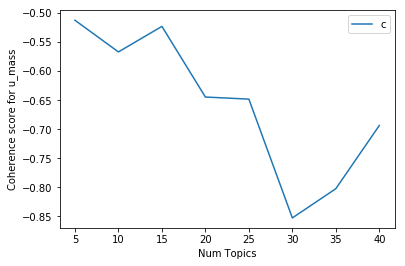

In [14]:
start = 5
limit = 41
step = 5
# Show graph
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_values_umass)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score for u_mass")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [15]:
#run LDA
#change num_topics if want to change the number of topics generated
lda_model = gensim.models.LdaModel(corpus, num_topics=30, id2word=dictionary, random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)


In [16]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.015*"christian" + 0.012*"dark" + 0.011*"cadet" + 0.011*"jlonso" + 0.010*"readm" + 0.010*"nuisanc" + 0.009*"speaker" + 0.009*"hill" + 0.008*"trigger" + 0.008*"death"
Topic: 1 
Words: 0.017*"mortichro" + 0.014*"presid" + 0.013*"mail" + 0.013*"retrivr" + 0.010*"postman" + 0.009*"earth" + 0.009*"taiwan" + 0.008*"postmen" + 0.007*"cough" + 0.007*"pkismeyea"
Topic: 2 
Words: 0.027*"sister" + 0.024*"mandarin" + 0.019*"heaven" + 0.014*"figur" + 0.013*"towel" + 0.010*"parad" + 0.010*"cold" + 0.010*"nope" + 0.009*"tree" + 0.009*"impress"
Topic: 3 
Words: 0.041*"ledditglobel" + 0.025*"wing" + 0.017*"spec" + 0.015*"lactos" + 0.013*"blowjob" + 0.013*"intoler" + 0.011*"syndrom" + 0.011*"daysncount" + 0.010*"silli" + 0.010*"thebigsplat"
Topic: 4 
Words: 0.136*"toilet" + 0.067*"author" + 0.059*"water" + 0.034*"flush" + 0.033*"clean" + 0.029*"shit" + 0.021*"public" + 0.021*"wash" + 0.015*"bowl" + 0.014*"floor"
Topic: 5 
Words: 0.000*"ploy" + 0.000*"remors" + 0.000*"jailtim" + 0.000*"